# Libraries

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image

# Part 1

## Part A (Build a simple model)

In [2]:
# We design a simple neural netwrok to work with (ResNet or VGG are computationally xpensive)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Convolutional + pooling layers
        x = self.pool(F.relu(self.conv1(x)))  # Output size: 32 x 16 x 16
        x = self.pool(F.relu(self.conv2(x)))  # Output size: 64 x 8 x 8
        x = self.pool(F.relu(self.conv3(x)))  # Output size: 128 x 4 x 4
        x = self.pool(F.relu(self.conv4(x)))  # Output size: 256 x 2 x 2

        # Flatten the output from convolution layers to feed into fully connected layers
        x = x.view(-1, 256 * 2 * 2)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [3]:
# Transformations for pre-processing (convert images to tensor, normalize them)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean and std for CIFAR-10
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the classes we want to select: Airplane (index 0) and Automobile (index 1)
class_indices = [0, 1]  # CIFAR-10 class indices for Airplane and Automobile

# Filter the training dataset
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in class_indices]
train_subset = Subset(train_dataset, train_indices)

# Filter the test dataset
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in class_indices]
test_subset = Subset(test_dataset, test_indices)

# Create DataLoader for training and testing
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Example to check the dataset
for images, labels in train_loader:
    print(images.shape, labels)  # Print shape of images and labels (batch size, channels, height, width)
    break

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([32, 3, 32, 32]) tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1])


## Part B and C (Train and Plot the accuracy)

Epoch [1/10], Train Loss: 0.3540, Train Accuracy: 84.08%, Test Loss: 0.2673, Test Accuracy: 88.20%
Epoch [2/10], Train Loss: 0.1662, Train Accuracy: 93.22%, Test Loss: 0.1542, Test Accuracy: 93.30%
Epoch [3/10], Train Loss: 0.1164, Train Accuracy: 95.48%, Test Loss: 0.1202, Test Accuracy: 95.20%
Epoch [4/10], Train Loss: 0.0794, Train Accuracy: 96.92%, Test Loss: 0.1244, Test Accuracy: 94.55%
Epoch [5/10], Train Loss: 0.0546, Train Accuracy: 98.05%, Test Loss: 0.1361, Test Accuracy: 95.70%
Epoch [6/10], Train Loss: 0.0384, Train Accuracy: 98.59%, Test Loss: 0.1678, Test Accuracy: 94.50%
Epoch [7/10], Train Loss: 0.0321, Train Accuracy: 98.86%, Test Loss: 0.1294, Test Accuracy: 95.65%
Epoch [8/10], Train Loss: 0.0229, Train Accuracy: 99.09%, Test Loss: 0.1469, Test Accuracy: 95.45%
Epoch [9/10], Train Loss: 0.0223, Train Accuracy: 99.22%, Test Loss: 0.1742, Test Accuracy: 95.40%
Epoch [10/10], Train Loss: 0.0241, Train Accuracy: 99.15%, Test Loss: 0.1264, Test Accuracy: 96.25%


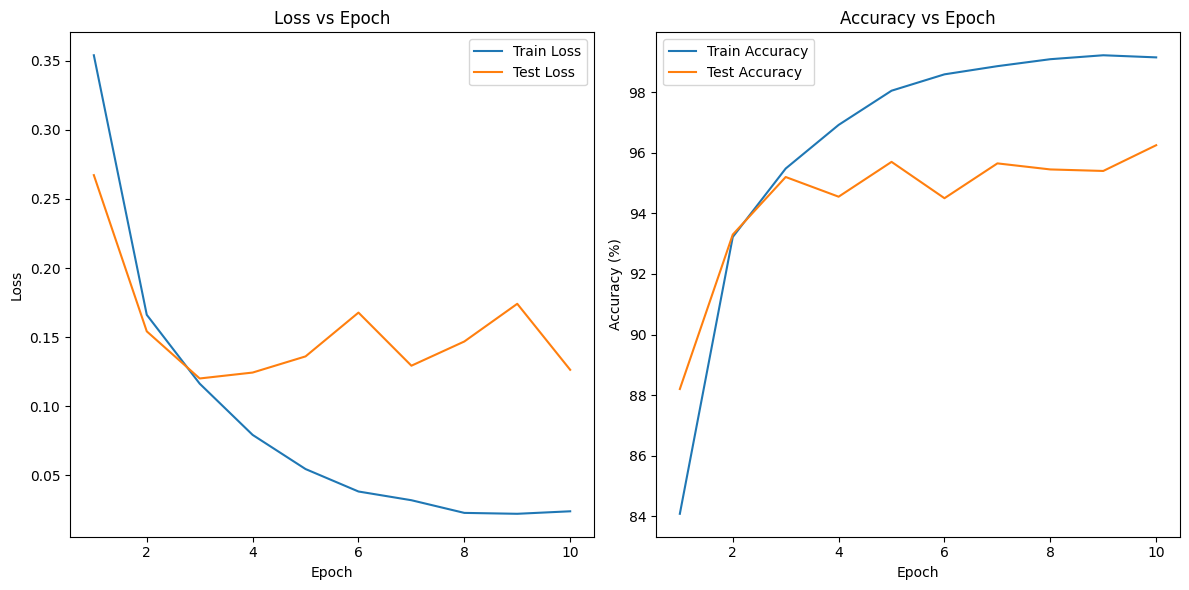

In [4]:
# Instantiate the model, loss function, and optimizer (we use cross-entropy)
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss and accuracy tracking
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Testing Phase
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)

    # Print statistics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plotting the loss and accuracy for both train and test sets
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Part D (featute maps)

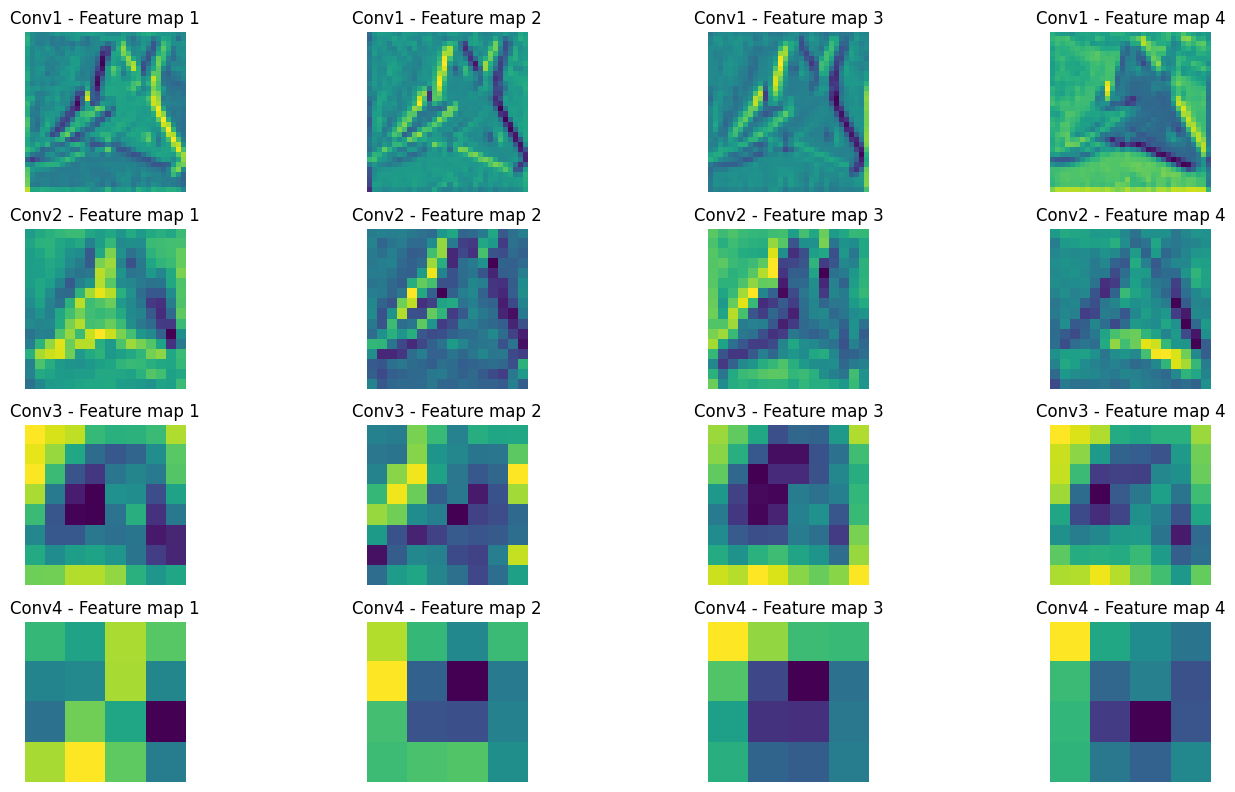

In [5]:
# Function to get feature maps from the CNN model
def get_feature_maps(model, input_image):
    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    # Register hooks for all convolutional layers
    model.conv1.register_forward_hook(hook_fn)
    model.conv2.register_forward_hook(hook_fn)
    model.conv3.register_forward_hook(hook_fn)
    model.conv4.register_forward_hook(hook_fn)

    # Forward pass to extract feature maps
    with torch.no_grad():
        model(input_image.unsqueeze(0))  # Add batch dimension

    return feature_maps

# Select a random image from the training set
random_idx = np.random.randint(0, len(train_loader.dataset))
sample_image, _ = train_loader.dataset[random_idx]

# Get the feature maps from the model
feature_maps = get_feature_maps(model, sample_image)

# Normalize the feature maps for better contrast
def normalize_feature_map(fmap):
    fmap_min = fmap.min()
    fmap_max = fmap.max()
    return (fmap - fmap_min) / (fmap_max - fmap_min)  # Normalize between 0 and 1

# Plot the feature maps
def plot_feature_maps(feature_maps):
    # Plot the feature maps from all convolutional layers
    num_layers = len(feature_maps)
    plt.figure(figsize=(15, 8))  # Adjust the figure size to fit more feature maps

    for layer_idx in range(num_layers):
        fmap = feature_maps[layer_idx]  # Feature maps from the current layer
        num_fmaps = fmap.size(1)  # Number of feature maps (channels)
        num_plots = min(num_fmaps, 4)  # Plot at most 4 feature maps per layer

        for i in range(num_plots):
            plt.subplot(num_layers, 4, layer_idx * 4 + i + 1)  # Arrange plots in rows for each layer
            plt.imshow(normalize_feature_map(fmap[0, i].cpu().numpy()), cmap='viridis')
            plt.axis('off')
            plt.title(f'Conv{layer_idx + 1} - Feature map {i + 1}')

    plt.tight_layout(pad=1.0)  # Adjust the padding to avoid overlap
    plt.show()

# Plot the feature maps
plot_feature_maps(feature_maps)


# Part 2: Triplet Loss

In [22]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Euclidean distance between anchor and positive, anchor and negative
        pos_distance = torch.norm(anchor - positive, p=2, dim=1)
        neg_distance = torch.norm(anchor - negative, p=2, dim=1)

        # Triplet loss: max(0, d(a, p) - d(a, n) + margin) (I took this from wiki pedia)
        loss = torch.mean(torch.clamp(pos_distance - neg_distance + self.margin, min=0))
        return loss

In [26]:
# I am writing another class that is simpler because previous neural network was computationally expensive for tripletloss
class CNNEmbedding(nn.Module):
    def __init__(self):
        super(CNNEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def freeze_fc_layers(self):
        """Freeze the fully connected layers."""
        for param in self.fc1.parameters():
            param.requires_grad = False
        for param in self.fc2.parameters():
            param.requires_grad = False


In [27]:
# We should write TripletLoss class ourselves.
class TripletDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.class_to_indices = {}

        # Group the dataset by classes
        for idx, (_, label) in enumerate(dataset):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get anchor and its label
        anchor, label = self.dataset[idx]

        # Positive sample: same class as anchor
        positive_idx = np.random.choice(self.class_to_indices[label])
        positive, _ = self.dataset[positive_idx]

        # Negative sample: different class from anchor
        negative_label = np.random.choice(list(self.class_to_indices.keys()))
        while negative_label == label:
            negative_label = np.random.choice(list(self.class_to_indices.keys()))
        negative_idx = np.random.choice(self.class_to_indices[negative_label])
        negative, _ = self.dataset[negative_idx]

        if self.transform:
            # Transform only if the image is a PIL Image
            anchor = self.transform(anchor) if isinstance(anchor, Image.Image) else anchor
            positive = self.transform(positive) if isinstance(positive, Image.Image) else positive
            negative = self.transform(negative) if isinstance(negative, Image.Image) else negative

        return anchor, positive, negative


Files already downloaded and verified
Epoch [1/10], Train Loss: 0.7358, Train Accuracy: 67.11%, Val Loss: 0.6563, Val Accuracy: 70.44%
Epoch [2/10], Train Loss: 0.6564, Train Accuracy: 70.74%, Val Loss: 0.6364, Val Accuracy: 72.27%
Epoch [3/10], Train Loss: 0.6314, Train Accuracy: 71.78%, Val Loss: 0.6104, Val Accuracy: 72.78%
Epoch [4/10], Train Loss: 0.6155, Train Accuracy: 72.51%, Val Loss: 0.6014, Val Accuracy: 73.17%
Epoch [5/10], Train Loss: 0.6043, Train Accuracy: 73.26%, Val Loss: 0.5993, Val Accuracy: 73.45%
Epoch [6/10], Train Loss: 0.5885, Train Accuracy: 74.04%, Val Loss: 0.5842, Val Accuracy: 74.24%
Epoch [7/10], Train Loss: 0.5878, Train Accuracy: 74.23%, Val Loss: 0.5993, Val Accuracy: 73.52%
Epoch [8/10], Train Loss: 0.5771, Train Accuracy: 74.41%, Val Loss: 0.5795, Val Accuracy: 74.18%
Epoch [9/10], Train Loss: 0.5700, Train Accuracy: 74.92%, Val Loss: 0.5629, Val Accuracy: 75.11%
Epoch [10/10], Train Loss: 0.5660, Train Accuracy: 74.94%, Val Loss: 0.5588, Val Accuracy

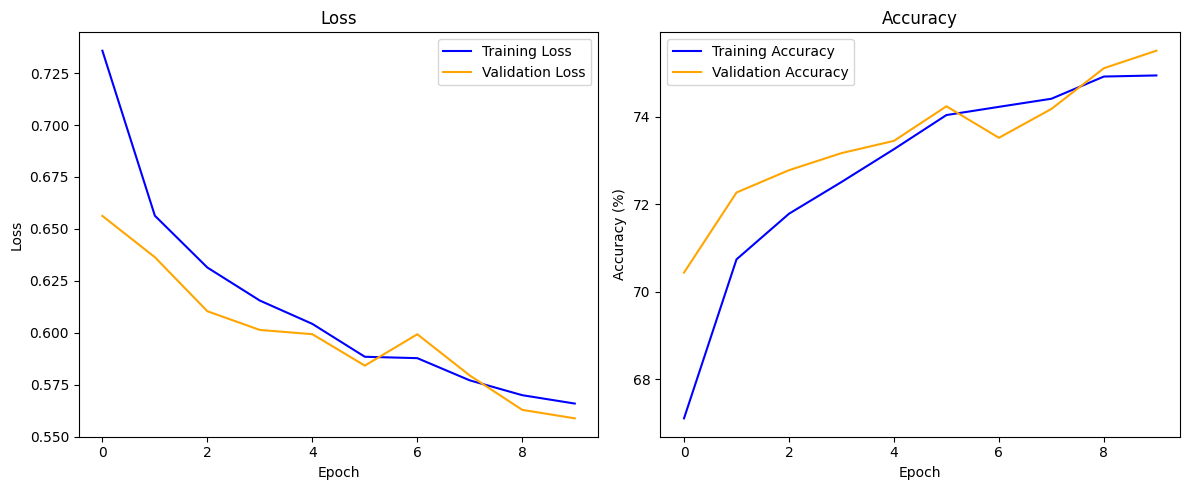

In [28]:
# Define the transformation for pre processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Split into training and validation sets
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

# Create DataLoader objects
train_loader = DataLoader(TripletDataset(train_dataset, transform=transform), batch_size=32, shuffle=True)
val_loader = DataLoader(TripletDataset(val_dataset, transform=transform), batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNNEmbedding()
model.cuda()  # Use GPU if available

# Freeze the fully connected layers
model.freeze_fc_layers()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the triplet loss
criterion = TripletLoss(margin=1.0)

# Function to calculate Euclidean distance
def euclidean_distance(x1, x2):
    return torch.sqrt(torch.sum((x1 - x2) ** 2, dim=1))

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_triplets = 0

    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        optimizer.zero_grad()

        # Forward pass
        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        # Compute loss
        loss = criterion(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate accuracy
        positive_distance = euclidean_distance(anchor_output, positive_output)
        negative_distance = euclidean_distance(anchor_output, negative_output)
        correct_train_predictions += torch.sum(positive_distance < negative_distance).item()
        total_train_triplets += anchor.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = correct_train_predictions / total_train_triplets * 100
    train_accuracies.append(avg_train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_triplets = 0

    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

            # Forward pass
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            # Compute loss
            loss = criterion(anchor_output, positive_output, negative_output)
            total_val_loss += loss.item()

            # Calculate accuracy
            positive_distance = euclidean_distance(anchor_output, positive_output)
            negative_distance = euclidean_distance(anchor_output, negative_output)
            correct_val_predictions += torch.sum(positive_distance < negative_distance).item()
            total_val_triplets += anchor.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    avg_val_accuracy = correct_val_predictions / total_val_triplets * 100
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%")

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function to get feature maps from the CNN model
def get_feature_maps(model, input_image):
    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    # Register hooks for all convolutional layers
    model.conv1.register_forward_hook(hook_fn)
    model.conv2.register_forward_hook(hook_fn)

    # Forward pass to extract feature maps
    with torch.no_grad():
        model(input_image.unsqueeze(0))  # Add batch dimension

    return feature_maps

# Select a random image from the training set
random_idx = np.random.randint(0, len(train_loader.dataset))
sample_image, _ = train_loader.dataset[random_idx]

# Get the feature maps from the model
feature_maps = get_feature_maps(model, sample_image)

# Normalize the feature maps for better contrast
def normalize_feature_map(fmap):
    fmap_min = fmap.min()
    fmap_max = fmap.max()
    return (fmap - fmap_min) / (fmap_max - fmap_min)  # Normalize between 0 and 1

# Plot the feature maps
def plot_feature_maps(feature_maps):
    # Plot the feature maps from all convolutional layers
    num_layers = len(feature_maps)
    plt.figure(figsize=(15, 8))  # Adjust the figure size to fit more feature maps

    for layer_idx in range(num_layers):
        fmap = feature_maps[layer_idx]  # Feature maps from the current layer
        num_fmaps = fmap.size(1)  # Number of feature maps (channels)
        num_plots = min(num_fmaps, 4)  # Plot at most 4 feature maps per layer

        for i in range(num_plots):
            plt.subplot(num_layers, 4, layer_idx * 4 + i + 1)  # Arrange plots in rows for each layer
            plt.imshow(normalize_feature_map(fmap[0, i].cpu().numpy()), cmap='viridis')
            plt.axis('off')
            plt.title(f'Conv{layer_idx + 1} - Feature map {i + 1}')

    plt.tight_layout(pad=1.0)  # Adjust the padding to avoid overlap
    plt.show()

# Plot the feature maps
plot_feature_maps(feature_maps)


# Part 3: Comparing

Feature Maps:
Triplet loss and cross-entropy loss differ in the quality of feature maps by emphasizing different aspects of learning. Triplet loss encourages the model to learn feature representations that distinctly separate similar and dissimilar items in the feature space, resulting in more discriminative and well-separated feature maps. In contrast, cross-entropy loss focuses on classification accuracy by minimizing the prediction error for each class, often leading to smoother and more generalized feature maps that prioritize correct label prediction rather than fine-grained class separation.

Accuracy: In terms of final accuracy, cross-entropy loss typically leads to higher classification accuracy because it directly optimizes for correct label prediction, making it well-suited for tasks where the goal is accurate classification. On the other hand, triplet loss focuses on learning a more discriminative feature space by optimizing the distance between similar and dissimilar samples. While this can improve performance in tasks like retrieval or face recognition, where the relative similarity between samples matters, it might not always result in the highest classification accuracy compared to cross-entropy loss. Therefore, for pure classification tasks, cross-entropy loss generally provides better final accuracy.

Convergence: In terms of convergence, cross-entropy loss generally converges faster because it directly minimizes the classification error, providing a clear and straightforward objective for the model to optimize. This makes it more stable and efficient for tasks like classification. On the other hand, triplet loss can take longer to converge, as it requires careful balancing between positive and negative pairs during training. This can lead to slower progress, especially if the data is not well-sampled or the margin between positive and negative pairs is not optimized, making it more challenging to achieve stable convergence.